In [1]:

import re 
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!pip install neattext



     |████████████████████████████████| 114 kB 5.2 MB/s 


In [3]:
import neattext.functions as nfx
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from nltk.corpus import stopwords
from keras.preprocessing.text import one_hot
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, Dropout
from keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [4]:
train_df = pd.read_csv('/content/train.txt',header=None, sep=';', names=['Text','Emotion'])


In [5]:
valid_df = pd.read_csv('/content/val.txt',header=None, sep=';', names=['Text','Emotion'])

In [6]:
test_df = pd.read_csv('/content/test.txt',header=None, sep=';', names=['Text','Emotion'])

In [7]:
train_df.head()


,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [8]:
test_df.head()

,Text,Emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [9]:
valid_df.head()

,Text,Emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


In [10]:
train_df.isnull().sum()


Text       0
Emotion    0
dtype: int64

Text(0, 0.5, 'Count')

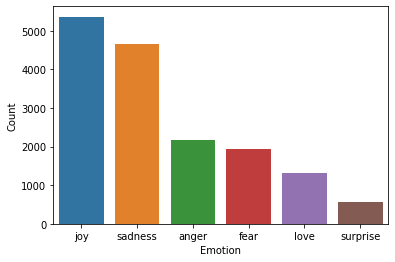

In [11]:
counts = train_df['Emotion'].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Emotion')
plt.ylabel('Count')

In [12]:
train_df['length'] = train_df['Text'].apply(len)
train_df.head()

,Text,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20


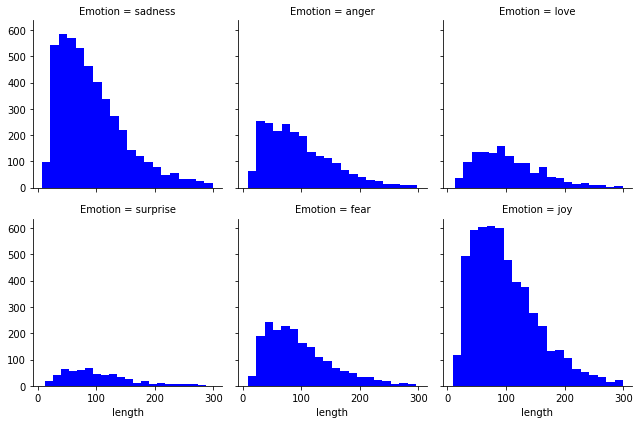

In [13]:
length_text = sns.FacetGrid(data=train_df, col='Emotion', col_wrap=3)
length_text.map(plt.hist, 'length', bins=20, color='b')

In [14]:
lb = LabelEncoder()
train_df['Label'] = lb.fit_transform(train_df['Emotion'])
valid_df['Label'] = lb.fit_transform(valid_df['Emotion'])
test_df['Label'] = lb.fit_transform(test_df['Emotion'])

In [15]:
vocab_size = 1000
len_sentence=150

In [16]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
def text_prepare(data, column):
    print(data.shape)
    stemmer = PorterStemmer()
    corpus = []
    
    for text in data[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        
        text = text.lower()
        text = text.split()
        
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        
        corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    embeddec_doc = pad_sequences(sequences=one_hot_word,
                              maxlen=len_sentence,
                              padding="pre")
    print(data.shape)
    return embeddec_doc

In [18]:
X_train=text_prepare(train_df, "Text")
X_valid =text_prepare(valid_df, "Text")
X_test=text_prepare(test_df, "Text")

(16000, 4)
(16000, 4)
(2000, 3)
(2000, 3)
(2000, 3)
(2000, 3)


In [19]:
y_train = train_df['Label']
y_valid = valid_df['Label']
y_test = test_df['Label']

In [20]:
enc = OneHotEncoder()


y_train = np.array(y_train)
y_train = enc.fit_transform(y_train.reshape(-1,1)).toarray()


y_test = np.array(y_test)
y_test = enc.fit_transform(y_test.reshape(-1,1)).toarray()


y_valid = np.array(y_valid)
y_valid = enc.fit_transform(y_valid.reshape(-1,1)).toarray()

In [21]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=150, input_length=len_sentence))
model.add(Dropout(0.2))
model.add(LSTM(200))
model.add(Dropout(0.3))
model.add(Dense(120, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(6, activation="softmax"))

In [22]:
model.compile(optimizer="Adam", loss = "categorical_crossentropy", metrics=["accuracy"])



my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              mode='auto')]




In [26]:

hist = model.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_data=(X_valid, y_valid),verbose = 1, callbacks=my_callbacks)



Epoch 1/50
500/500 [==============================] - 20s 41ms/step - loss: 0.2098 - accuracy: 0.9128 - val_loss: 1.0765 - val_accuracy: 0.7410
Epoch 2/50
500/500 [==============================] - 21s 42ms/step - loss: 0.1897 - accuracy: 0.9202 - val_loss: 1.2340 - val_accuracy: 0.7320
Epoch 3/50
500/500 [==============================] - 20s 40ms/step - loss: 0.1812 - accuracy: 0.9246 - val_loss: 1.1993 - val_accuracy: 0.7315
Epoch 4/50
500/500 [==============================] - 20s 40ms/step - loss: 0.1692 - accuracy: 0.9296 - val_loss: 1.2609 - val_accuracy: 0.7355
Epoch 5/50
500/500 [==============================] - 20s 40ms/step - loss: 0.1534 - accuracy: 0.9387 - val_loss: 1.4108 - val_accuracy: 0.7370
Epoch 6/50
500/500 [==============================] - 20s 40ms/step - loss: 0.1485 - accuracy: 0.9404 - val_loss: 1.4913 - val_accuracy: 0.7325


In [1]:
accuracy = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss=hist.history['loss']
val_loss=hist.history['val_loss']
epochs=range(len(accuracy))

plt.plot(epochs,accuracy,'b', label='Training accuracy')
plt.plot(epochs,val_acc,'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'b', label='Training loss')
plt.plot(epochs,val_loss,'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: name 'hist' is not defined